# Lab 1: Model Compression (Quantization and Pruning)

## General introduction
In this lab, you will learn how to use Mase to compress a Bert model using quantization and pruning. You will build off the checkpoint from Lab 2, where we fine tuned a Bert model for sequence classification using the LoRA adapter. You will quantize the model to fixed-point precision and then prune the model to reduce the number of parameters. After each stage, you’ll run further fine tuning to recover the performance lost during compression.

## Implementation tasks
1. In Tutorial 3, you quantized every Linear layer in the model to the provided configuration. Now, explore a range of fixed point widths from 4 to 32. \
a. Plot a figure where the x-axis is the fixed point width and the y-axis is the highest achieved accuracy on the IMDb dataset, following the procedure in Tutorial 3. \
b. Plot separate curves for PTQ and QAT at each precision to show the effect of post-quantization finetuning.

In [ ]:
from transformers import AutoModelForSequenceClassification
from chop import MaseGraph
import chop.passes as passes
from pathlib import Path
from chop import MaseGraph

# Remove FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
checkpoint = "DeepWokLab/bert-tiny"
tokenizer_checkpoint = "DeepWokLab/bert-tiny"
dataset_name = "imdb"

mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_2_lora")

/home/infres/dfouchard-21/miniconda3/envs/mase/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_s

In [3]:
from chop.tools import get_tokenized_dataset, get_trainer
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

INFO     Tokenizing dataset imdb with AutoTokenizer for DeepWokLab/bert-tiny.


In [6]:
import warnings
PTQ_acc = []
QAT_acc = []
precisions = [4, 8, 16, 24, 32]
for precision in precisions:
    # Reload base model
    mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_2_lora")
    print(f"==== Precision : {precision} bits====")
    width = precision
    frac_width = int(precision / 2)
    quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": width,
            "data_in_frac_width": frac_width,
            # weight
            "weight_width": width,
            "weight_frac_width": frac_width,
            # bias
            "bias_width": width,
            "bias_frac_width": frac_width,
        }
        },
    }
    print("1. Quantization...")
    mg, _ = passes.quantize_transform_pass(
        mg,
        pass_args=quantization_config,
        )
    
    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )
    print("2. Evaluation...")
    eval_results = trainer.evaluate()
    print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")
    PTQ_acc.append(eval_results['eval_accuracy'])

    print("3. QAT...")
    # Evaluate accuracy
    trainer.train()
    eval_results = trainer.evaluate()
    print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")
    QAT_acc.append(eval_results['eval_accuracy'])


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.


==== Precision : 4 bits====
1. Quantization...
2. Evaluation...


/home/infres/dfouchard-21/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.5
3. QAT...


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


Evaluation accuracy: 0.5


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found 

==== Precision : 8 bits====
1. Quantization...
2. Evaluation...


/home/infres/dfouchard-21/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.82452
3. QAT...


Step,Training Loss
500,0.396300
1000,0.391400
1500,0.402000
2000,0.381900
2500,0.394700
3000,0.389500


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found 

Evaluation accuracy: 0.84448
==== Precision : 16 bits====
1. Quantization...
2. Evaluation...


/home/infres/dfouchard-21/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.83836
3. QAT...


Step,Training Loss
500,0.377000
1000,0.381100
1500,0.387900
2000,0.374200
2500,0.382700
3000,0.389700


Evaluation accuracy: 0.84644


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found 

==== Precision : 24 bits====
1. Quantization...
2. Evaluation...


/home/infres/dfouchard-21/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.83716
3. QAT...


Step,Training Loss
500,0.377500
1000,0.380800
1500,0.388200
2000,0.374000
2500,0.383500
3000,0.389400


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found 

Evaluation accuracy: 0.84648
==== Precision : 32 bits====
1. Quantization...
2. Evaluation...


/home/infres/dfouchard-21/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


KeyboardInterrupt: 

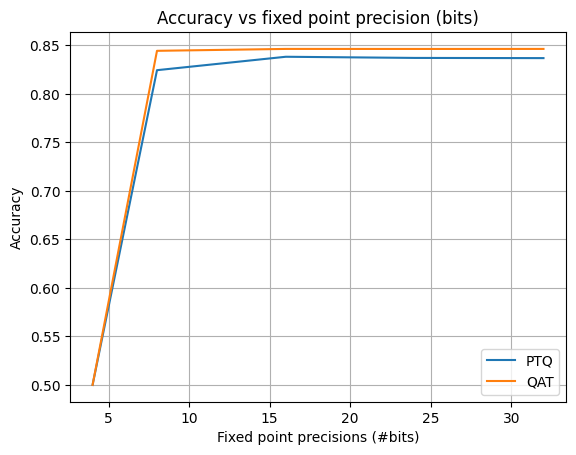

In [9]:
import matplotlib.pyplot as plt
plt.plot(precisions, PTQ_acc, label="PTQ")
plt.plot(precisions, QAT_acc, label="QAT")
plt.title("Accuracy vs fixed point precision (bits)")
plt.xlabel("Fixed point precisions (#bits)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

From the results above, we can see that we can safely quantize the model to 8 bits and perform some ft without losing much accuracy. We will use 8 bits for the rest of the lab.

In [4]:
mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_3_qat")
trainer = get_trainer(
            model=mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
        )
eval_results = trainer.evaluate()
baseline_acc = eval_results['eval_accuracy']
print(f"Evaluation accuracy: {baseline_acc}")


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
/home/infres/dfouchard-21/mase

Evaluation accuracy: 0.84448


In [ ]:
sparcities = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
methods = ["random", "l1-norm"]
acc = {"random":[baseline_acc], "l1-norm":[baseline_acc]}
for method in methods:
    for sparcity in sparcities:
        mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_3_qat")
        print(f"===={method} pruning with sparcity={sparcity}====")
        pruning_config = {
            "weight": {
                "sparsity": sparcity,
                "method": method,
                "scope": "local",
            },
            "activation": {
                "sparsity": sparcity,
                "method": method,
                "scope": "local",
            },
        }
        
        mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)
        # Evaluate accuracy
        trainer = get_trainer(
            model=mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
        )
        eval_results = trainer.evaluate()
        print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")
        acc[method].append(eval_results['eval_accuracy'])


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_

====random pruning with sparcity=0.3====


/home/infres/dfouchard-21/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.5298


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_

====random pruning with sparcity=0.5====


/home/infres/dfouchard-21/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.509
====random pruning with sparcity=0.7====


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_

Evaluation accuracy: 0.49844


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_

====l1-norm pruning with sparcity=0.3====


/home/infres/dfouchard-21/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.83712


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_

====l1-norm pruning with sparcity=0.5====


/home/infres/dfouchard-21/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.6592


/home/infres/dfouchard-21/mase/src/chop/ir/graph/mase_graph.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
INFO     Pruning module: bert_

====l1-norm pruning with sparcity=0.7====


/home/infres/dfouchard-21/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.51688


In [7]:
import matplotlib.pyplot as plt

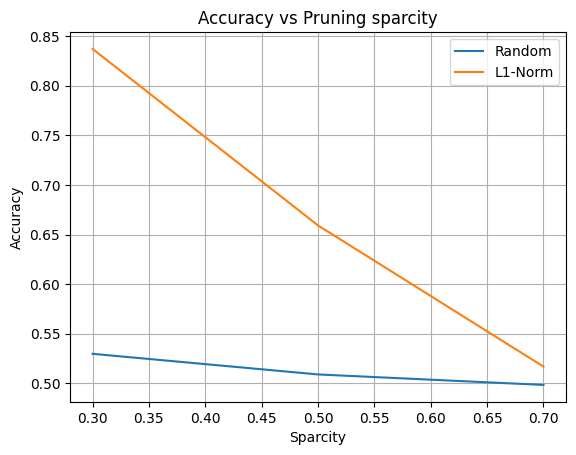

In [8]:
plt.plot(sparcities, acc["random"], label="Random")
plt.plot(sparcities, acc["l1-norm"], label="L1-Norm")
plt.title("Accuracy vs Pruning sparcity")
plt.xlabel("Sparcity")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()